In [1]:
# start SparkSession
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("project").getOrCreate()
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-pastel')

# 1. STORIES

In [2]:
# read in the dataset stories
data_df = spark.read\
  .format('csv')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load('s3://bigdataproject233/stories.csv')

In [3]:
 data_df.show()

+-------+------------+-----+------------+--------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|     id|          by|score|        time|             time_ts|               title|                 url|                text|deleted|dead|descendants|      author|
+-------+------------+-----+------------+--------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|6940813|   sarath237|  0.0|1387536270.0|2013-12-20 10:44:...| Sheryl Brindo Ho...|http://www.youtub...| Sheryl Brindo Ho...|   null|True|       null|   sarath237|
|6991401|123123321321|  0.0|1388508751.0|2013-12-31 16:52:...|Are you people al...|                null|They&#x27;re pret...|   null|True|       null|123123321321|
|1531556|         ssn|  0.0|1279617234.0|2010-07-20 09:13:...|New UI for Google...|http://googlesyst...|Again following o...|   null|null|        0.0|         ssn|
|5012398|       

In [4]:
data_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- by: string (nullable = true)
 |-- score: string (nullable = true)
 |-- time: string (nullable = true)
 |-- time_ts: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- deleted: string (nullable = true)
 |-- dead: string (nullable = true)
 |-- descendants: string (nullable = true)
 |-- author: string (nullable = true)



In [5]:
data_df.count()

2069464

In [6]:
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

story_df = data_df.select(data_df['id'].cast(IntegerType()),
                     data_df['score'].cast(IntegerType()),
                     data_df['time_ts'].cast('timestamp'),
                     data_df['title'],
                     data_df['url'],
                     data_df['text'],
                     data_df['deleted'],
                     data_df['dead'],
                     data_df['descendants'].cast(IntegerType()),
                     data_df['author']
                             )


In [7]:
story_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- score: integer (nullable = true)
 |-- time_ts: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- deleted: string (nullable = true)
 |-- dead: string (nullable = true)
 |-- descendants: integer (nullable = true)
 |-- author: string (nullable = true)



In [8]:
story_df.show(10)

+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|     id|score|            time_ts|               title|                 url|                text|deleted|dead|descendants|      author|
+-------+-----+-------------------+--------------------+--------------------+--------------------+-------+----+-----------+------------+
|6940813|    0|2013-12-20 10:44:30| Sheryl Brindo Ho...|http://www.youtub...| Sheryl Brindo Ho...|   null|True|       null|   sarath237|
|6991401|    0|2013-12-31 16:52:31|Are you people al...|                null|They&#x27;re pret...|   null|True|       null|123123321321|
|1531556|    0|2010-07-20 09:13:54|New UI for Google...|http://googlesyst...|Again following o...|   null|null|          0|         ssn|
|5012398|    0|2013-01-05 12:11:17|Historic website ...|http://webscrapin...|Python script to ...|   null|null|          0|        hoju|
|7214182|    0|2014-05-31 18:42:20|      

In [9]:
# create temp table
story_df.createOrReplaceTempView('ini_story')

In [10]:
story_df.select("id").distinct().count()

1959840

In [11]:
story_df.select("title").distinct().count()

1759584

In [12]:
# filter the dataset
sqlStatement = """
SELECT * 
FROM ini_story
WHERE id is not NULL 
and score is not NULL 
and time_ts is not NULL 
and title is not NULL 
and url is not NULL
and deleted is NULL
and dead is NULL
and descendants is not NULL
and author is not NULL 
"""
clean_story_df1 = spark.sql(sqlStatement)
clean_story_df1.createOrReplaceTempView('story1')

In [13]:
clean_story_df1.count()

1354684

In [14]:
# 改之前的数供参考
#clean_story_df.count()

1807831

In [64]:
# get hostname of url as web

sqlStatement = """
SELECT id, score, time_ts,title,text,descendants,author,
regexp_extract(url, '([a-z]+).(com|net|co|cn|org|ru|de|br|uk|pl|ir|it|in|fr|au|jp|info|to|ca)', 1) as web
FROM story1 
"""

clean_story_df2 = spark.sql(sqlStatement)
clean_story_df2.createOrReplaceTempView('story')

In [65]:
# website information
# Where are the stories coming from? or what are the most popular sources?

sqlStatement = """
SELECT COUNT(id) AS num, web
FROM story
WHERE web != '' and web !='www'
GROUP BY web
ORDER BY num DESC
LIMIT 20
"""
web_df1 = spark.sql(sqlStatement)

In [66]:
### to be visual
# show top 10
web_df1.show(10)

+-----+-----------+
|  num|        web|
+-----+-----------+
|35097|     github|
|29733| techcrunch|
|26550|    nytimes|
|21101|    youtube|
|17742|     medium|
|17331|   blogspot|
|14425|     google|
|14039|        bbc|
|13508|arstechnica|
|13153|      wired|
+-----+-----------+
only showing top 10 rows



Text(0, 0.5, 'Number')

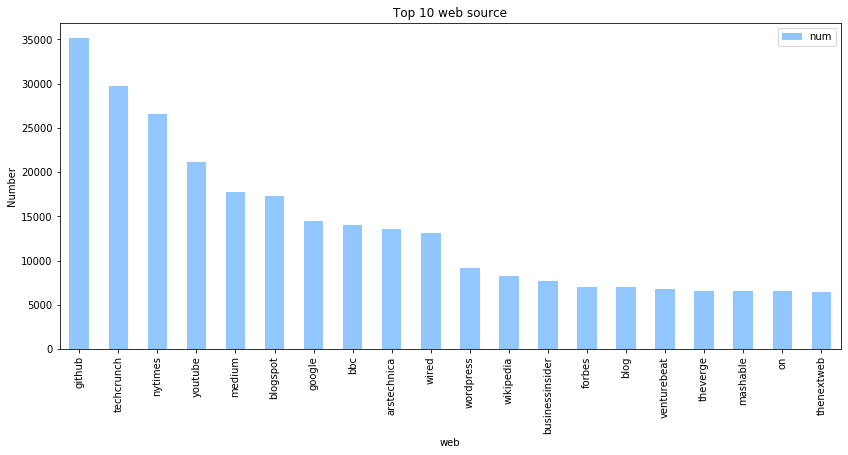

In [68]:
web_df1 = web_df1.toPandas()
web_df1.plot(x='web', y='num', 
                    kind="bar",figsize=(14,6),
                    title='Top 10 web source').set_ylabel("Number")

In [121]:
# score information
# From which website the story will have a high score in total?
sqlStatement = """
SELECT AVG(score) as avg_score, web
FROM story
WHERE web != '' and web !='www'
GROUP BY web
ORDER BY avg_score DESC
LIMIT 20
"""
web_df2 = spark.sql(sqlStatement)


In [122]:
### to be visual
# show top 10
web_df2.show(10)

+---------+--------------------+
|avg_score|                 web|
+---------+--------------------+
|   1768.0|          heartbleed|
|   1445.0|           bekkelund|
|   1323.0|          spritelamp|
|   1215.0|spotthedrowningchild|
|   1167.0|    standardmarkdown|
|   1086.0|            jeffepst|
|   1055.0|       projectnaptha|
|    965.0|               porta|
|    925.0|     gabrielecirulli|
|    910.0|    gameaboutsquares|
+---------+--------------------+
only showing top 10 rows



Text(0, 0.5, 'Score')

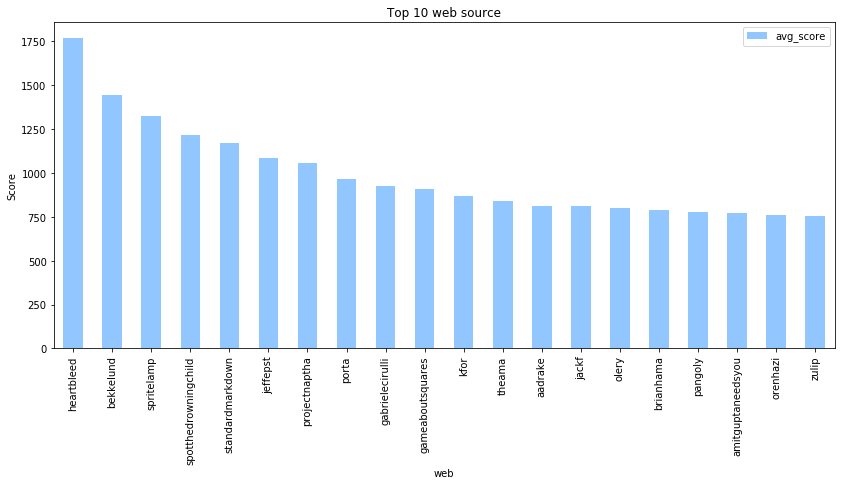

In [123]:
web_df2 = web_df2.toPandas()
web_df2.plot(x='web', y='avg_score', 
                    kind="bar",figsize=(14,6),
                    title='Top 10 web source').set_ylabel("Score")

In [29]:
# story number distribution in terms of time
# What is the trend of story numbers from 2006-2015 in Hacker News?

sqlStatement = """
SELECT COUNT(id) AS story_num, 
year(time_ts) as year
FROM story
GROUP BY year
ORDER BY year
"""
story_time_df1 = spark.sql(sqlStatement)

In [30]:
story_time_df1.show()

+---------+----+
|story_num|year|
+---------+----+
|       45|2006|
|    19065|2007|
|    56112|2008|
|    80414|2009|
|   126610|2010|
|   182196|2011|
|   218117|2012|
|   244181|2013|
|   232685|2014|
|   195259|2015|
+---------+----+



Text(0, 0.5, 'Number')

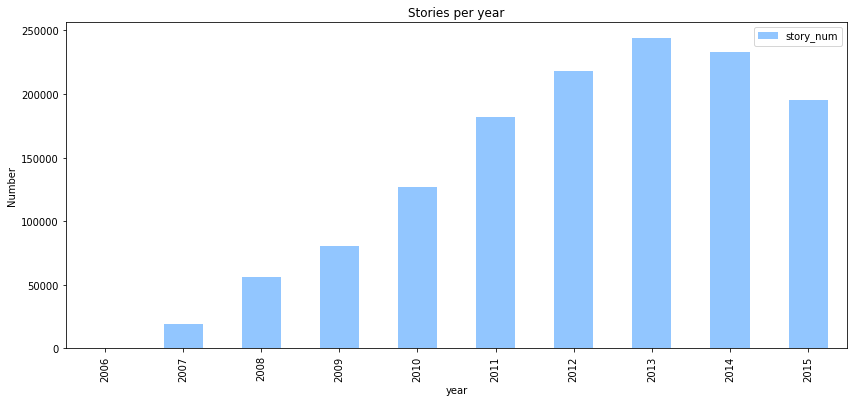

In [31]:
story_time_df1 = story_time_df1.toPandas()
story_time_df1.plot(x='year', y='story_num', 
                    kind="bar",figsize=(14,6),
                    title='Stories per year', style = 'ggplot').set_ylabel("Number")

In [32]:
# story number distribution in terms of time
# What is the most popular/active time during a day in pubulishing a story?

sqlStatement = """
SELECT COUNT(id) AS story_num, 
hour(time_ts) as hour
FROM story
GROUP BY hour
ORDER BY story_num DESC
"""
story_time_df2 = spark.sql(sqlStatement)

In [33]:
story_time_df2.show(24)

+---------+----+
|story_num|hour|
+---------+----+
|    93909|  16|
|    92949|  17|
|    90629|  15|
|    88890|  18|
|    82766|  14|
|    81380|  19|
|    76528|  20|
|    70811|  13|
|    70633|  21|
|    60463|  22|
|    55523|  12|
|    51507|  23|
|    45249|   0|
|    43107|  11|
|    40900|   1|
|    38248|   2|
|    36314|   3|
|    36285|  10|
|    35238|   4|
|    33923|   9|
|    33067|   5|
|    32968|   8|
|    31819|   6|
|    31578|   7|
+---------+----+



Text(0, 0.5, 'Number')

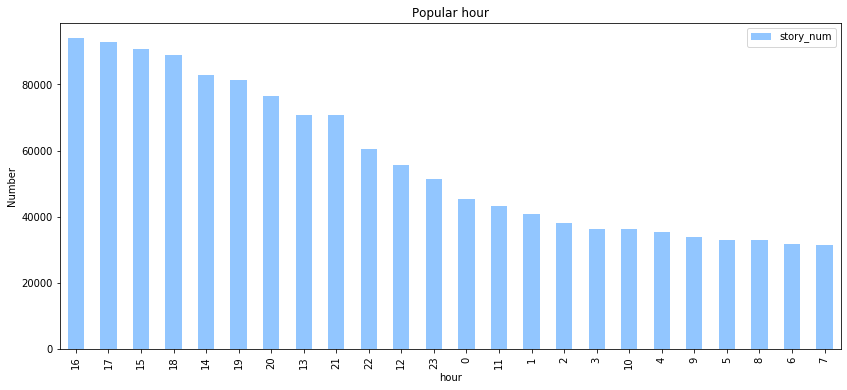

In [34]:
story_time_df2 = story_time_df2.toPandas()
story_time_df2.plot(x='hour', y='story_num', 
                    kind="bar",figsize=(14,6),
                    title='Popular hour').set_ylabel("Number")

In [35]:
# score information
# what is the average score of those story?
spark.sql("select min(score),max(score),avg(score) from story").collect()

[Row(min(score)=0, max(score)=4339, avg(score)=12.954768049227717)]

In [36]:
# author/user information 
# decending by total_score 
sqlStatement = """SELECT SUM(score) as total_score,author,
SUM(descendants) as total_decendants,
count(id) as total_stories
FROM story
GROUP BY author
ORDER BY total_score DESC
LIMIT 20
"""
user_df = spark.sql(sqlStatement)
#user_df.createOrReplaceTempView("user")

In [37]:
user_df.show(10)

+-----------+-----------+----------------+-------------+
|total_score|     author|total_decendants|total_stories|
+-----------+-----------+----------------+-------------+
|      75245|ColinWright|           29947|         3574|
|      63337| shawndumas|           25296|         6467|
|      59381|    llambda|           20131|         2571|
|      56227|      fogus|           20989|         2327|
|      53281|      danso|           22792|         2571|
|      51790|       cwan|           23679|         6984|
|      51705|        luu|           19692|         2247|
|      48635|  ssclafani|           23950|         1289|
|      41031| Libertatea|           18953|         2222|
|      40923|      evo_9|           16070|         5405|
+-----------+-----------+----------------+-------------+
only showing top 10 rows



Text(0, 0.5, 'Score')

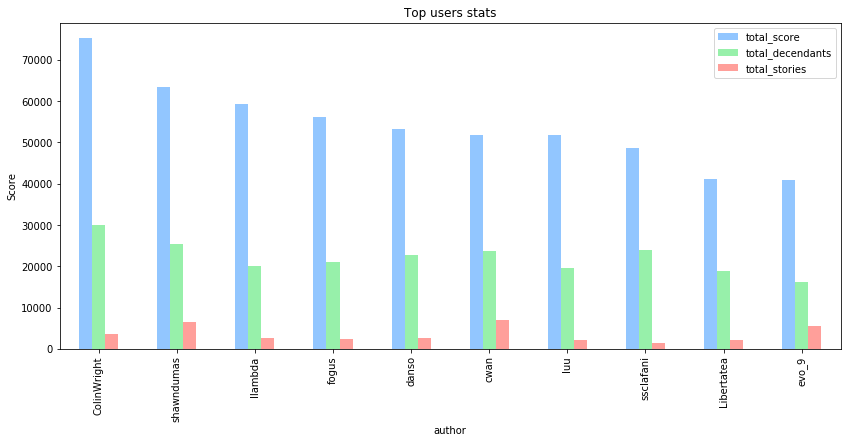

In [38]:
user_df = user_df.toPandas()
user_df.sort_values("total_score")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Score")

In [39]:
# author/user information 
# decending by total_stories 
sqlStatement = """SELECT SUM(score) as total_score, author,
SUM(descendants) as total_decendants,
count(id) as total_stories
FROM story
GROUP BY author
ORDER BY total_stories DESC
LIMIT 20
"""
user_df2 = spark.sql(sqlStatement)

In [40]:
user_df2.show(10)

+-----------+-----------+----------------+-------------+
|total_score|     author|total_decendants|total_stories|
+-----------+-----------+----------------+-------------+
|      51790|       cwan|           23679|         6984|
|      63337| shawndumas|           25296|         6467|
|      40923|      evo_9|           16070|         5405|
|      29280|      nickb|           11716|         4256|
|      26227|   iProject|           11726|         4233|
|      28207|   bootload|           11236|         4089|
|      29096|     edw519|           13421|         3756|
|      29485|     nreece|           12515|         3594|
|      75245|ColinWright|           29947|         3574|
|      36056| tokenadult|           19846|         3562|
+-----------+-----------+----------------+-------------+
only showing top 10 rows



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Stories')

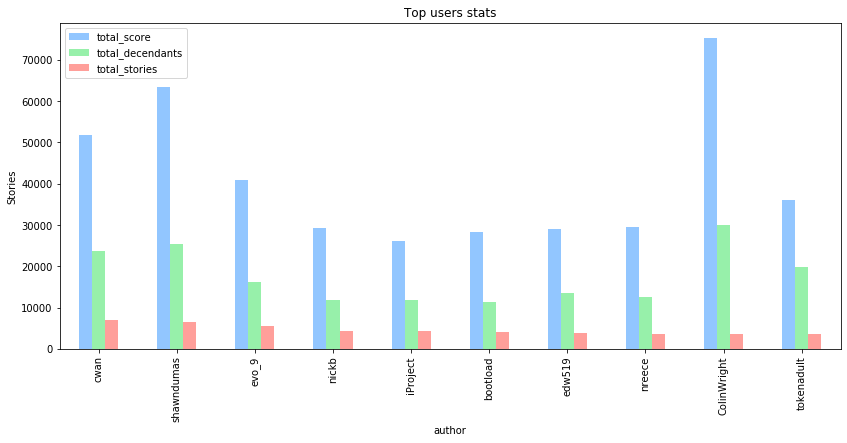

In [42]:
user_df2 = user_df2.toPandas()
user_df2.sort_values("total_stories")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Stories")

In [43]:
# author/user information 
# decending by avg_score 
sqlStatement = """SELECT SUM(score) as total_score, author,
SUM(descendants) as total_decendants, SUM(score)/count(id) as avg_score,
count(id) as total_stories
FROM story
GROUP BY author
ORDER BY avg_score DESC
LIMIT 20
"""
user_df3 = spark.sql(sqlStatement)

In [44]:
user_df3.show(10)

+-----------+---------------+----------------+---------+-------------+
|total_score|         author|total_decendants|avg_score|total_stories|
+-----------+---------------+----------------+---------+-------------+
|       1543|    realfuncode|             526|   1543.0|            1|
|       2905|     frederfred|             412|   1452.5|            2|
|       1282|          rcina|             249|   1282.0|            1|
|       1257|         kvargs|             558|   1257.0|            1|
|       1248|        mmebane|             267|   1248.0|            1|
|       1227|FlemishBeeCycle|             444|   1227.0|            1|
|       1172|     hannahmitt|             136|   1172.0|            1|
|       1125|  afraidofadria|             985|   1125.0|            1|
|       4354|   patricktomas|             385|   1088.5|            4|
|       1032|       ikeellis|             542|   1032.0|            1|
+-----------+---------------+----------------+---------+-------------+
only s

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Score')

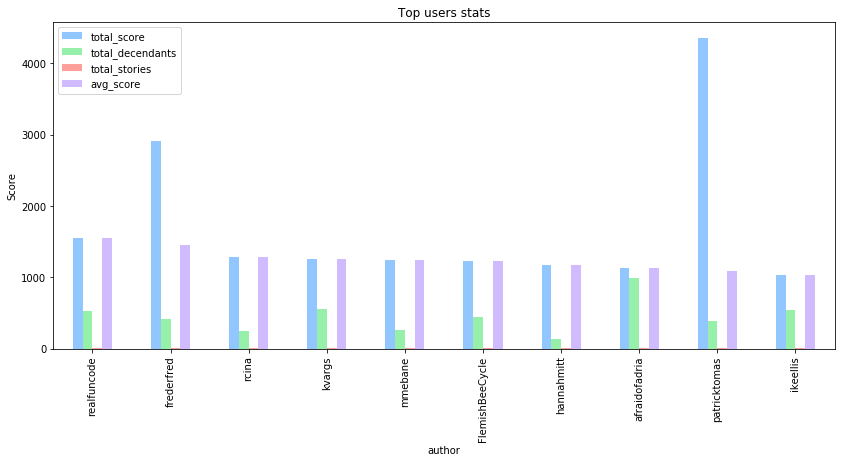

In [45]:
user_df3 = user_df3.toPandas()
user_df3.sort_values("avg_score")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories", 'avg_score'], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Score")

In [46]:
# if there is bias on YC
sqlStatement = """
SELECT score, title,id
FROM `story`
WHERE title like "%Y Combinator%" or title like "%YCombinator%" or title like "%ycombinator%" or title like "%y combinator%"
ORDER BY score  DESC
"""
YC_df = spark.sql(sqlStatement)

In [47]:
YC_df.distinct().show()

+-----+--------------------+-------+
|score|               title|     id|
+-----+--------------------+-------+
| 1065|Y Combinator is f...|5059806|
|  841|Y Combinator has ...|8033322|
|  705|Meet Watsi, Y Com...|5117385|
|  687|New: Apply to Y C...|3700712|
|  589|How I Got Kicked ...|2208155|
|  550|Benefits matter, ...|5409273|
|  549|What Happens At Y...|1733236|
|  542|How Y Combinator ...|3711008|
|  506|Y Combinator Numbers|2608440|
|  432|New Y Combinator ...|7972138|
|  425|Yuri Milner, SV A...|2154706|
|  380|Y Combinator And ...|8178450|
|  379|How I Crashed and...|8867335|
|  368|Early Photos of Y...|2942958|
|  366|Investment Firm Y...|3492711|
|  344|Y Combinator anno...|1898432|
|  342|Offer HN now at n...|1840060|
|  334|Startup developin...|7108684|
|  310|TempleOS is apply...|9246855|
|  310|Applications open...|3515307|
+-----+--------------------+-------+
only showing top 20 rows



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Score')

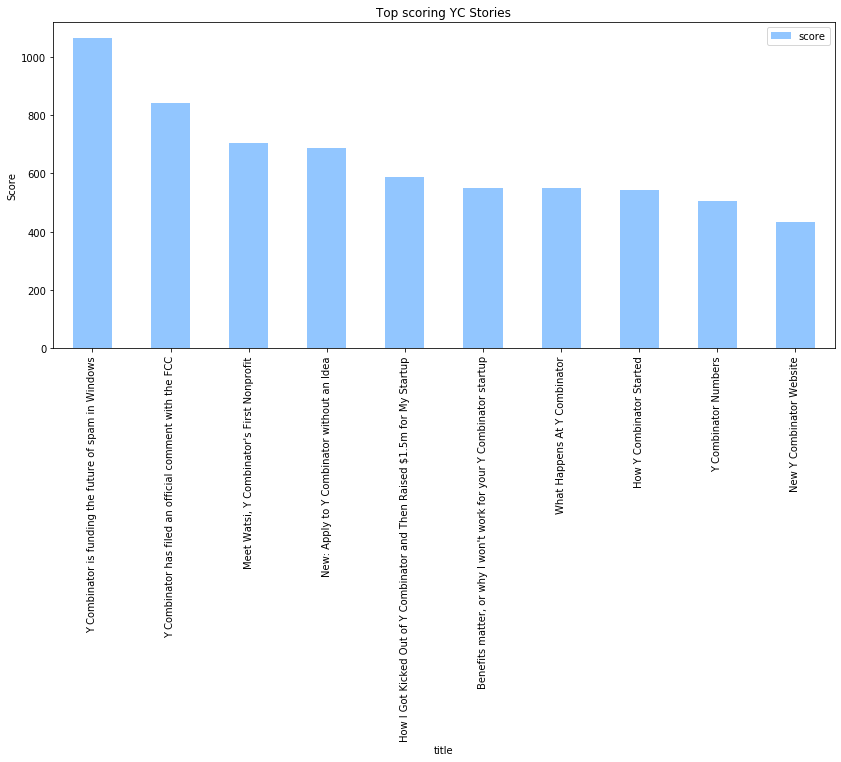

In [48]:
YC_df = YC_df.toPandas()
YC_df.sort_values("score")[::-1][:10].plot(x="title",y=["score"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top scoring YC Stories').set_ylabel("Score")

In [49]:
# stories of major companies over the year
# apple
sqlStatement = """
SELECT count(*) as total_stories, SUM(score) as total_score,
year(time_ts) as year
FROM story
WHERE title like "%apple%" or title like "%APPLE" or title like "%Apple"
GROUP BY year
ORDER BY year
"""
Comp_df1 = spark.sql(sqlStatement)

In [50]:
Comp_df1.distinct().show()

+-------------+-----------+----+
|total_stories|total_score|year|
+-------------+-----------+----+
|            1|          7|2006|
|           26|        104|2007|
|           41|        322|2008|
|           78|        723|2009|
|          160|       1860|2010|
|          295|       5102|2011|
|          317|       4788|2012|
|          224|       2267|2013|
|          154|       2237|2014|
|          134|       3611|2015|
+-------------+-----------+----+



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Stories')

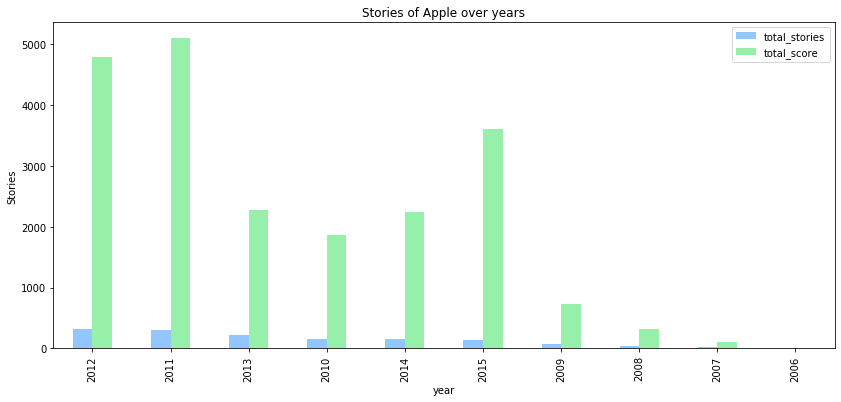

In [51]:
Comp_df1 = Comp_df1.toPandas()
Comp_df1.sort_values("total_stories")[::-1][:10].plot(x="year",y=["total_stories", 'total_score'], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Stories of Apple over years').set_ylabel("Stories")

In [102]:
# stories of major companies over the year
# google
sqlStatement = """
SELECT count(*) as total_stories, SUM(score) as total_score,
year(time_ts) as year
FROM story
WHERE title like "%google%" or title like "%GOOGLE" or title like "%Google"
GROUP BY year
ORDER BY year
"""
Comp_df2 = spark.sql(sqlStatement)

In [103]:
Comp_df2.distinct().show()

+-------------+-----------+----+
|total_stories|total_score|year|
+-------------+-----------+----+
|           95|        484|2007|
|          162|       1125|2008|
|          226|       2884|2009|
|          361|       6419|2010|
|          399|       8751|2011|
|          368|       7094|2012|
|          402|      10665|2013|
|          365|       7734|2014|
|          303|       9052|2015|
+-------------+-----------+----+



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Stories')

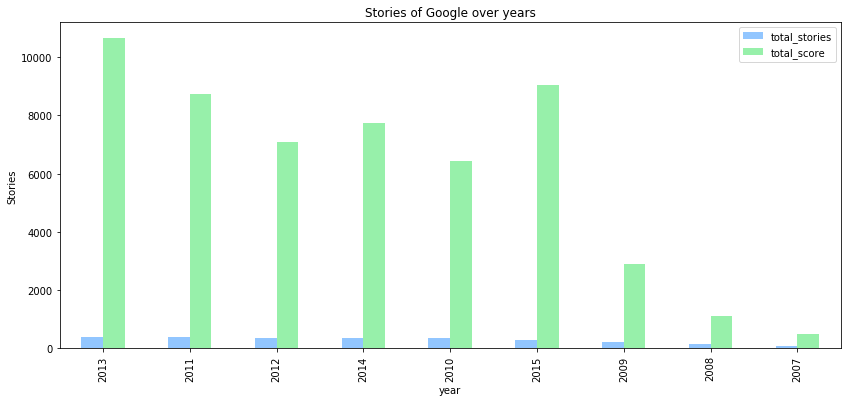

In [54]:
Comp_df2 = Comp_df2.toPandas()
Comp_df2.sort_values("total_stories")[::-1][:10].plot(x="year",y=["total_stories", 'total_score'], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Stories of Google over years').set_ylabel("Stories")

In [55]:
# stories of major companies over the year
# uber
sqlStatement = """
SELECT count(*) as total_stories, SUM(score) as total_score,
year(time_ts) as year
FROM story
WHERE title like "%uber%" or title like "%UBER" or title like "%Uber"
GROUP BY year
ORDER BY year
"""
Comp_df3 = spark.sql(sqlStatement)

In [56]:
Comp_df3.distinct().show()

+-------------+-----------+----+
|total_stories|total_score|year|
+-------------+-----------+----+
|            3|          3|2007|
|           19|        194|2008|
|           19|        943|2009|
|           53|       1088|2010|
|           49|        935|2011|
|           48|        864|2012|
|           55|        511|2013|
|          215|       2697|2014|
|          267|       3240|2015|
+-------------+-----------+----+



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Stories')

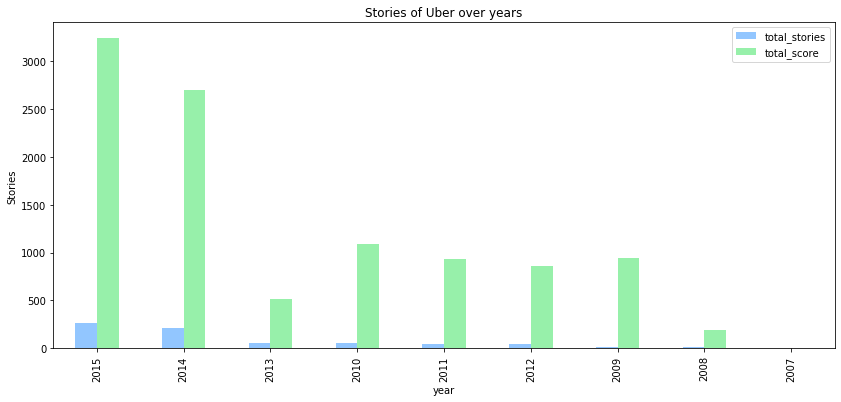

In [57]:
Comp_df3 = Comp_df3.toPandas()
Comp_df3.sort_values("total_stories")[::-1][:10].plot(x="year",y=["total_stories", 'total_score'], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Stories of Uber over years').set_ylabel("Stories")

# 2. COMMENTS

In [69]:
# read in the dataset comments
data_df2 = spark.read\
  .format('csv')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load('s3://chingsez/Final/comments.csv')

In [70]:
data_df2.show()

+--------------------+-------+------+----------+--------------------+--------------------+--------------------+--------------------+-------+-------+
|                  id|     by|author|      time|             time_ts|                text|              parent|             deleted|   dead|ranking|
+--------------------+-------+------+----------+--------------------+--------------------+--------------------+--------------------+-------+-------+
|             2701393|     5l|    5l|1309184881|2011-06-27 14:28:...|And the glazier w...|             2701243|                null|   null|      0|
|             5811403|     99|    99|1370234048|2013-06-03 04:34:...|Does canada have ...|             5804452|                null|   null|      0|
|               21623|     AF|    AF|1178992400|2007-05-12 17:53:...|"Speaking of Rail...|               21611|                null|   null|      0|
|            10159727|     EA|    EA|1441206574|2015-09-02 15:09:...|Humans and large ...|            1015

In [71]:
data_df2.printSchema()

root
 |-- id: string (nullable = true)
 |-- by: string (nullable = true)
 |-- author: string (nullable = true)
 |-- time: string (nullable = true)
 |-- time_ts: string (nullable = true)
 |-- text: string (nullable = true)
 |-- parent: string (nullable = true)
 |-- deleted: string (nullable = true)
 |-- dead: string (nullable = true)
 |-- ranking: string (nullable = true)



In [72]:
data_df2.count()

9796725

In [73]:
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType

comment_df = data_df2.select(
                     data_df2['id'].cast(IntegerType()),                    
                     data_df2['time_ts'].cast('timestamp'),                  
                     data_df2['text'],
                     data_df2['parent'].cast(IntegerType()),
                     #data_df2['deleted'],
                     #data_df2['dead'],
                     data_df2['author'],
                     data_df2['ranking'].cast(IntegerType())

                             )

In [74]:
comment_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- time_ts: timestamp (nullable = true)
 |-- text: string (nullable = true)
 |-- parent: integer (nullable = true)
 |-- author: string (nullable = true)
 |-- ranking: integer (nullable = true)



In [75]:
comment_df.show(10)

+--------+-------------------+--------------------+--------+------+-------+
|      id|            time_ts|                text|  parent|author|ranking|
+--------+-------------------+--------------------+--------+------+-------+
| 2701393|2011-06-27 14:28:01|And the glazier w...| 2701243|    5l|      0|
| 5811403|2013-06-03 04:34:08|Does canada have ...| 5804452|    99|      0|
|   21623|2007-05-12 17:53:20|"Speaking of Rail...|   21611|    AF|      0|
|10159727|2015-09-02 15:09:34|Humans and large ...|10159396|    EA|      0|
| 2988424|2011-09-12 18:53:00|I must say I reac...| 2988179|    Iv|      0|
| 3867418|2012-04-20 11:39:44|&#62; There's a w...| 3867404|    Iv|      0|
| 3925617|2012-05-03 20:26:05|I'm also in this ...| 3924840|    Iv|      0|
| 3107534|2011-10-13 15:34:04|how do you run un...|    null|    Iv|   null|
|    null|               null|                null|    null|  null|   null|
| 8409259|2014-10-04 11:20:47|Polio is not exte...| 8409226|    Iv|      0|
+--------+--

In [76]:
comment_df.createOrReplaceTempView('ini_comment')

In [77]:
comment_df.select("id").distinct().count()

8399564

In [78]:
clean_comment_df = spark.sql('select * from ini_comment where id is not NULL and time_ts is not NULL and text is not NULL and author is not NULL and ranking is not NULL')
clean_comment_df.createOrReplaceTempView('comment')

In [79]:
clean_comment_df.count()

6986995

In [80]:
clean_comment_df.show(10)

+--------+-------------------+--------------------+--------+------+-------+
|      id|            time_ts|                text|  parent|author|ranking|
+--------+-------------------+--------------------+--------+------+-------+
| 2701393|2011-06-27 14:28:01|And the glazier w...| 2701243|    5l|      0|
| 5811403|2013-06-03 04:34:08|Does canada have ...| 5804452|    99|      0|
|   21623|2007-05-12 17:53:20|"Speaking of Rail...|   21611|    AF|      0|
|10159727|2015-09-02 15:09:34|Humans and large ...|10159396|    EA|      0|
| 2988424|2011-09-12 18:53:00|I must say I reac...| 2988179|    Iv|      0|
| 3867418|2012-04-20 11:39:44|&#62; There's a w...| 3867404|    Iv|      0|
| 3925617|2012-05-03 20:26:05|I'm also in this ...| 3924840|    Iv|      0|
| 8409259|2014-10-04 11:20:47|Polio is not exte...| 8409226|    Iv|      0|
|   50570|2007-09-05 17:04:05|It was a risky jo...|   50556|    Jd|      0|
| 2600618|2011-05-30 22:34:14|"Looks good, ther...| 2600609|    Jd|      0|
+--------+--

In [81]:
# comment author/user information 
# who are the most contributive authors in Hacker News ?
## futhur to be done——can be joined with the most contirbutive authors in story

sqlStatement = """SELECT author,
        COUNT(id) AS total_comments
        From comment
        GROUP BY author
        ORDER BY total_comments DESC
        LIMIT 20
"""
comment_user_df = spark.sql(sqlStatement)

In [82]:
# show top 10
comment_user_df.show(10)

+------------+--------------+
|      author|total_comments|
+------------+--------------+
|     tptacek|         28605|
|    jacquesm|         19845|
|       DanBC|         10992|
|    jrockway|         10679|
|   anigbrowl|         10490|
|dragonwriter|         10203|
|         eru|          9979|
|     rbanffy|          9634|
|       sp332|          9547|
|     rayiner|          9403|
+------------+--------------+
only showing top 10 rows



Text(0, 0.5, 'Comments')

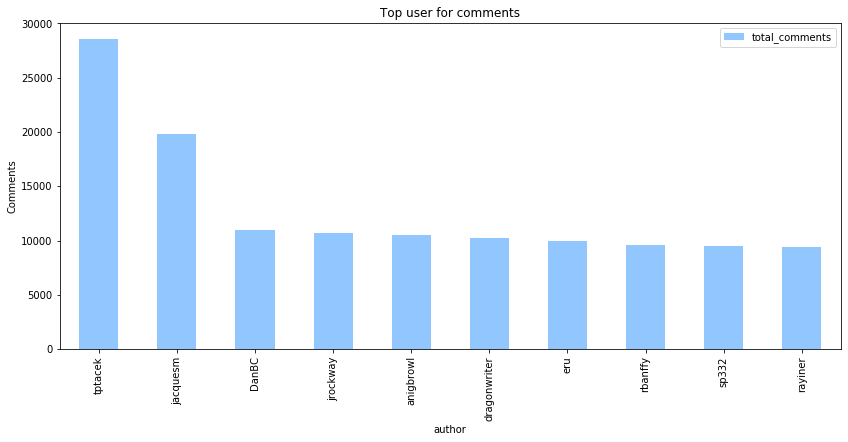

In [83]:
comment_user_df = comment_user_df.toPandas()
comment_user_df.sort_values("total_comments")[::-1][:10].plot(x="author",y='total_comments', 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top user for comments').set_ylabel("Comments")

In [84]:
# comment distribution in terms of time
# What is the trend of comment numbers from 2006-2016 in Hacker News?

sqlStatement = """
SELECT COUNT(id) AS comment_num, 
year(time_ts) as year
FROM comment
GROUP BY year
ORDER BY year
"""
comment_time_df2 = spark.sql(sqlStatement)

In [85]:
comment_time_df2.show()

+-----------+----+
|comment_num|year|
+-----------+----+
|         10|2006|
|      50982|2007|
|     195678|2008|
|     382490|2009|
|     658846|2010|
|     816999|2011|
|     975306|2012|
|    1415381|2013|
|    1348324|2014|
|    1142979|2015|
+-----------+----+



/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Text(0, 0.5, 'Comments')

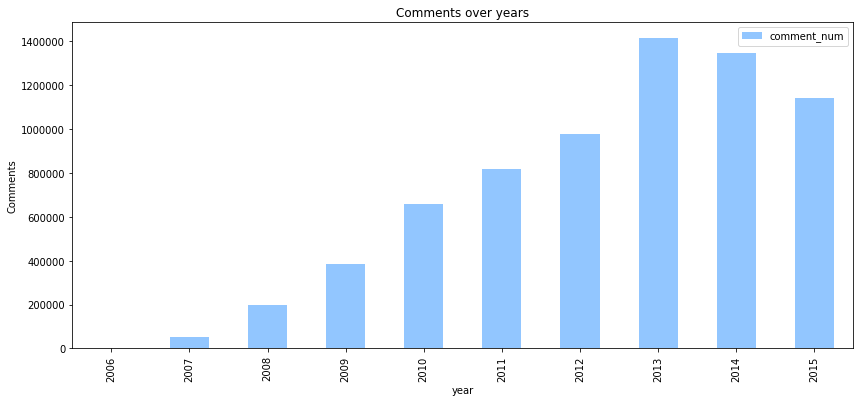

In [86]:
comment_time_df2 = comment_time_df2.toPandas()
comment_time_df2.plot(x="year",y='comment_num', 
                     kind="bar",figsize=(14,6),
                     title='Comments over years').set_ylabel("Comments")

In [87]:
# comment distribution in terms of time
# What is the most popular/active time during a day in pubulishing a comment?

sqlStatement = """
SELECT COUNT(id) AS comment_num, 
hour(time_ts) as hour
FROM comment
GROUP BY hour
ORDER BY comment_num DESC
"""
comment_time_df = spark.sql(sqlStatement)

In [88]:
comment_time_df.show(24)

+-----------+----+
|comment_num|hour|
+-----------+----+
|     451259|  17|
|     450094|  18|
|     437369|  16|
|     433640|  19|
|     421504|  20|
|     413518|  15|
|     398429|  21|
|     365798|  14|
|     353708|  22|
|     313262|  23|
|     295136|  13|
|     276703|   0|
|     251256|   1|
|     236036|   2|
|     224956|   3|
|     224367|  12|
|     210740|   4|
|     192913|   5|
|     180795|   6|
|     180141|  11|
|     172147|   7|
|     170884|   8|
|     168104|   9|
|     164236|  10|
+-----------+----+



Text(0, 0.5, 'Comments')

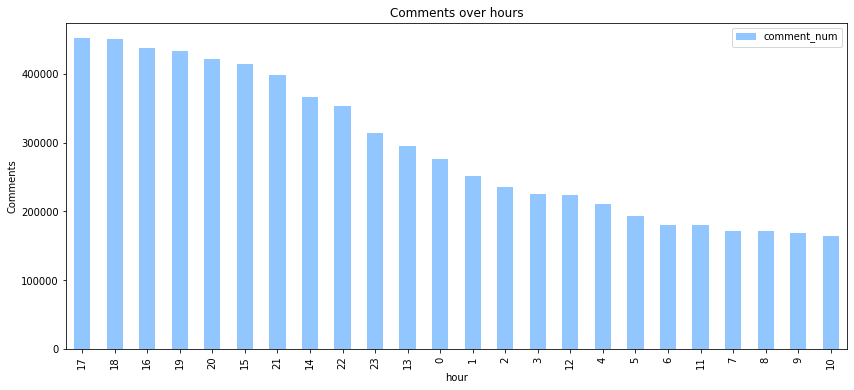

In [89]:
comment_time_df = comment_time_df.toPandas()
comment_time_df.plot(x="hour",y='comment_num', 
                     kind="bar",figsize=(14,6),
                     title='Comments over hours').set_ylabel("Comments")

In [90]:
# top(the hottest) comments with the most follow-up comment 
#编号没有什么实际意义，要保留吗？
sqlStatement = """
SELECT COUNT(id) AS followup_num, 
parent
FROM comment
WHERE parent is not NULL
GROUP BY parent
ORDER BY followup_num DESC
LIMIT 20
"""
comment_parent_df1 = spark.sql(sqlStatement)

In [91]:
# show top 10
comment_parent_df1.show(10)

+------------+--------+
|followup_num|  parent|
+------------+--------+
|         975|     363|
|         266| 7469115|
|         266| 9996333|
|         264| 9238839|
|         262| 9812245|
|         243| 7445761|
|         241|10152809|
|         239|  752262|
|         234| 9471287|
|         228| 9303396|
+------------+--------+
only showing top 10 rows



Text(0, 0.5, 'Follow-up')

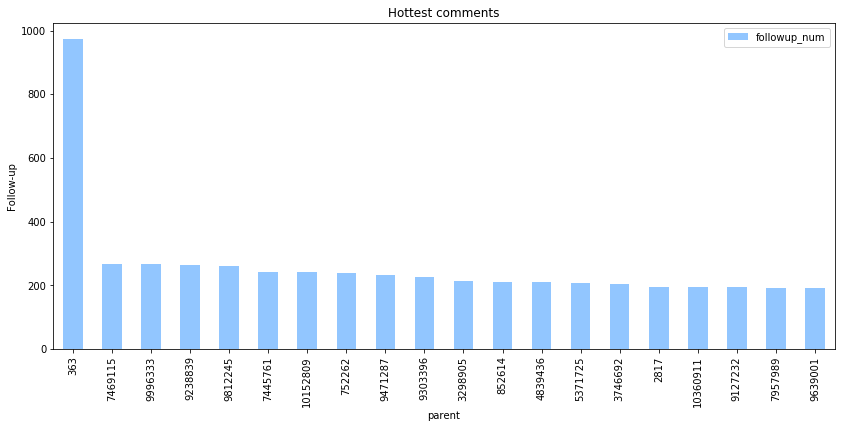

In [92]:
comment_parent_df1 = comment_parent_df1.toPandas()
comment_parent_df1.plot(x="parent",y='followup_num', 
                     kind="bar",figsize=(14,6),
                     title='Hottest comments').set_ylabel("Follow-up")

In [93]:
# ranking information
# what is the average ranking of those comments?

spark.sql("select min(ranking),max(ranking),avg(ranking) from comment").collect()

[Row(min(ranking)=-1051, max(ranking)=1131019295, avg(ranking)=58481.1891668736)]

In [114]:
# author/user's ranking information decending by avg ranking 
# who has the highest avg ranking?
#感觉有点问题
sqlStatement = """SELECT avg(ranking) as avg_ranking,author,
count(id) as total_comment
FROM comment
WHERE ranking > 0
GROUP BY author
ORDER BY avg(ranking) 
LIMIT 20
"""
comment_user_df1 = spark.sql(sqlStatement)

In [115]:
# show top 10
comment_user_df1.show(10)

+-----------+-------------+-------------+
|avg_ranking|       author|total_comment|
+-----------+-------------+-------------+
|        1.0|memetraversal|            1|
|        1.0|       Arkson|            1|
|        1.0|      apessoa|            1|
|        1.0|     bware218|            1|
|        1.0|       joekur|            1|
|        1.0|         asok|            1|
|        1.0| happy_camper|            1|
|        1.0|      fruneau|            1|
|        1.0|      bhavyam|            1|
|        1.0|     webspekt|            1|
+-----------+-------------+-------------+
only showing top 10 rows



Text(0, 0.5, 'Ranking')

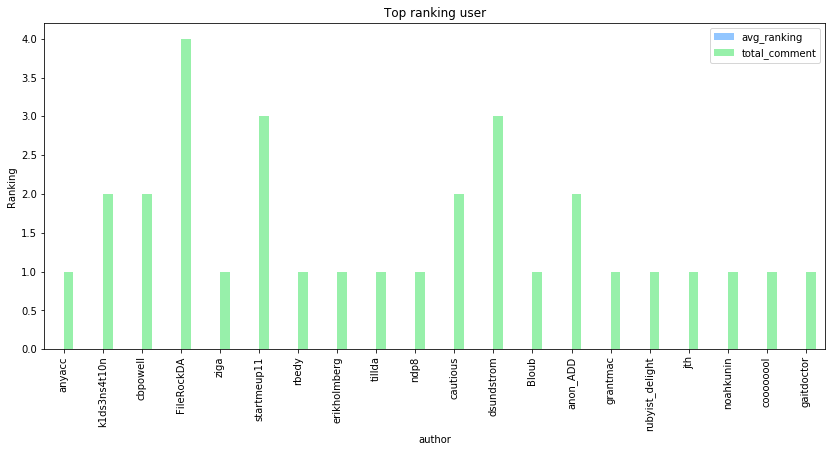

In [99]:
comment_user_df1 = comment_user_df1.toPandas()
comment_user_df1.plot(x="author",y=['avg_ranking', 'total_comment'], 
                     kind="bar",figsize=(14,6),
                     title='Top ranking user').set_ylabel("Ranking")

In [ ]:
spark.stop()